# Offline Phase: generating reduced coefficient maps

This notebook implements the generation of the maps of the reduced coefficients (obtained by GEIM and POD) using the following methods:

- Piecewise-Linear Interpolation
- Radial Basis Function (RBF) Interpolation

In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy import interpolate as interp

path_offline = './Offline_results/'

geim_var_names = ['norm_T']
pod_var_names  = ['p', 'U']

geim_tex_var_names = ['T']
pod_tex_var_names  = ['p', r'\mathbf{u}']

Let us import the reduced coefficients for GEIM (temperature) and POD (pressure and velocity)

In [2]:
geim_coeffs = pickle.load(open(path_offline+'coeffs.geim', 'rb'))
pod_coeffs  = pickle.load(open(path_offline+'coeffs.pod',  'rb'))

The snapshots are dependent on two different parameters: the Reynolds and the Richardson number, split into train and test set
\begin{equation}
Re_{train} = [15:5:150] \qquad\qquad Ri_{train} = [0.2:0.4:5]
\end{equation}

In [3]:
dRe = 5.
dRi = 0.4

# Train Parameters
Re_train = np.arange(15,  150+dRe/2, dRe)
Ri_train = np.arange(0.2,   5+dRi/2, dRi)

Ri, Re = np.meshgrid(Ri_train, Re_train)
mu_train = np.column_stack((Re.flatten(), Ri.flatten()))

## Mapping the coefficients of the observable fields

In this section, the reduced coordinate obtained by the GEIM algorithm, i.e., $\boldsymbol{\beta}^T$, observable fields (only temperature in this case) will be mapped
\begin{equation*}
\mathcal{F}_T: \boldsymbol{\mu} \longrightarrow \boldsymbol{\beta}^T(\boldsymbol{\mu})
\end{equation*}

In [4]:
geim_maps = dict()

Mmax = 30

for field in geim_var_names:
    geim_maps[field] = dict()
    geim_maps[field]['LinInt'] = [interp.LinearNDInterpolator(mu_train, geim_coeffs[field][:, rank]) for rank in range(Mmax)]
    geim_maps[field]['Clough'] = [interp.CloughTocher2DInterpolator(mu_train, geim_coeffs[field][:, rank], rescale=True) for rank in range(Mmax)]

Before plotting, we can store them using `pickle`

In [5]:
pickle.dump(geim_maps, open(path_offline+'maps.geim', 'wb'))

Let us plot the maps for the first 8 coefficients

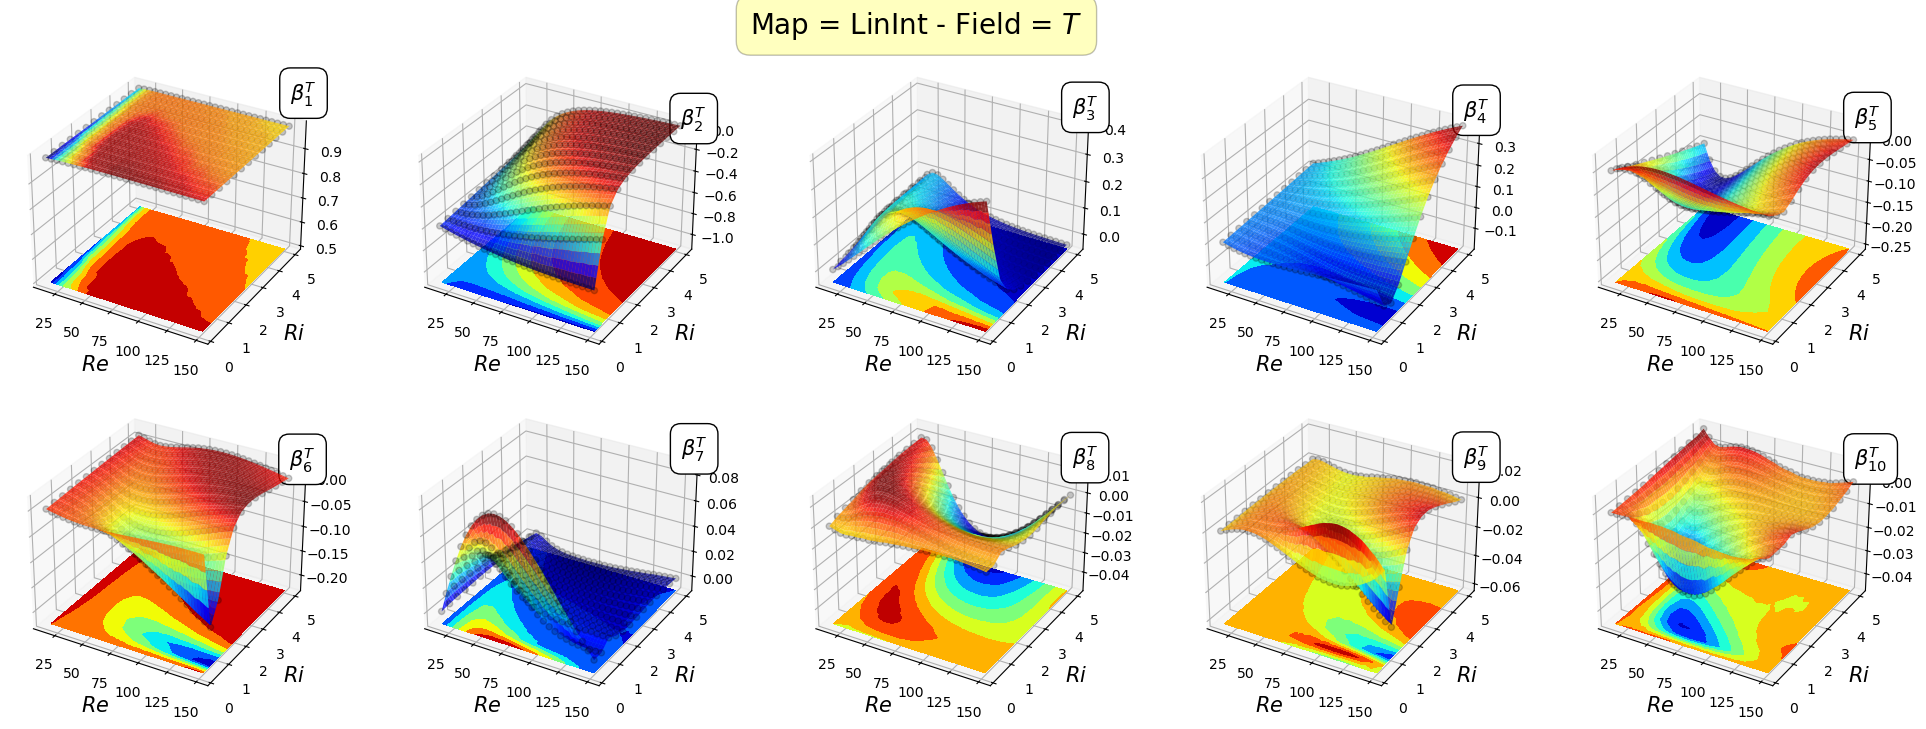

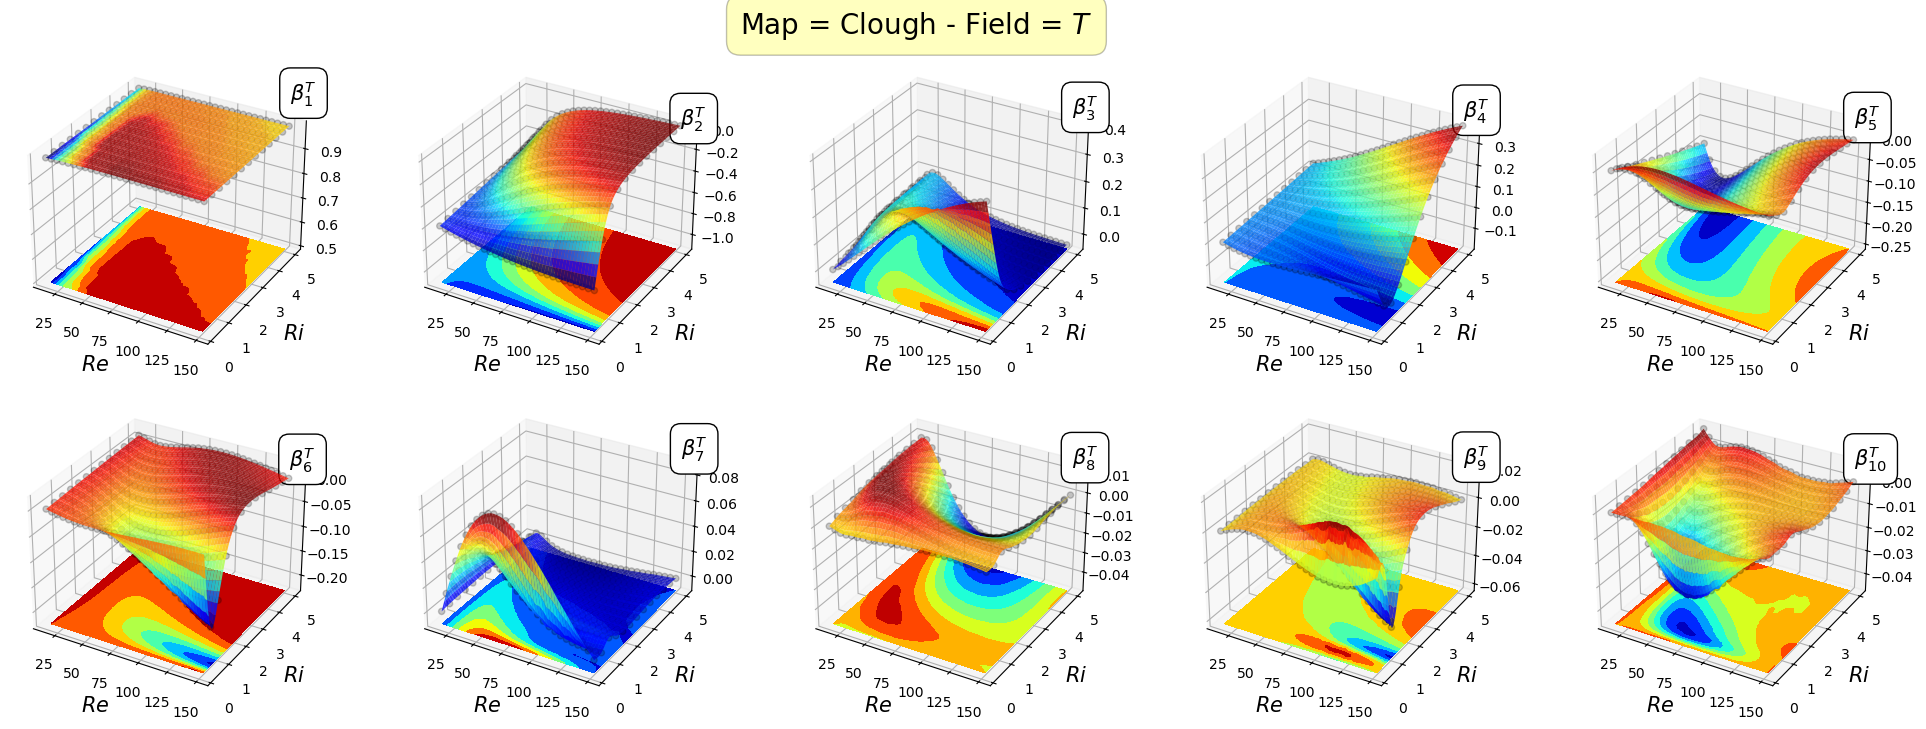

In [25]:
field_i = 0
field = geim_var_names[field_i]

Re_plot = np.linspace(min(mu_train[:,0]), max(mu_train[:,0]), 200)
Ri_plot = np.linspace(min(mu_train[:,1]), max(mu_train[:,1]), 100)

xx, yy = np.meshgrid(Re_plot, Ri_plot)

nrows = 2
ncols = 5

for map in list(geim_maps[field].keys()):
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(5 * ncols, 4 * nrows),
                            subplot_kw={'projection': '3d'})
    axs = axs.flatten()

    for rank in range(nrows * ncols):
        axs[rank].scatter(mu_train[:,0], mu_train[:,1], geim_coeffs[field][:, rank], c='k', marker ='o', alpha = 0.2)
        
        eval_map = geim_maps[field][map][rank](xx, yy)
        surf = axs[rank].plot_surface(xx, yy, eval_map, cmap = cm.jet, alpha=0.8)
        axs[rank].contourf(xx, yy, eval_map, cmap = cm.jet, offset = min(geim_coeffs[field][:, rank]) * (1 - 0.5 * np.sign(min(geim_coeffs[field][:, rank]))))
        axs[rank].set(zlim=(min(geim_coeffs[field][:, rank]) * (1 - 0.5 * np.sign(min(geim_coeffs[field][:, rank]))), max(geim_coeffs[field][:, rank])))
        
        axs[rank].set_xlabel(r'$Re$', fontsize=15)
        axs[rank].set_ylabel(r'$Ri$', fontsize=15)
        axs[rank].text(max(Re_plot), max(Ri_plot), max(geim_coeffs[field][:, rank]) * 1.1, r'$\beta_{'+str(rank+1)+'}^'+geim_tex_var_names[field_i]+'$', fontsize=15, 
                       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=1))
    
    fig.subplots_adjust(hspace=0.1, wspace=0.05, top = 0.925)
    fig.suptitle('Map = '+map+' - Field = $'+geim_tex_var_names[field_i]+'$', fontsize=20, bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.25))

## Mapping the coefficients of the non-observable fields

In this section, the reduced coordinate obtained by the POD procedure, i.e., $\boldsymbol{\alpha}^p$ and $\boldsymbol{\alpha}^\mathbf{u}$, non-observable fields (pressure and velocity in this case) will be mapped
\begin{equation*}
\mathcal{F}_p: \boldsymbol{\mu} \longrightarrow \boldsymbol{\alpha}^p(\boldsymbol{\mu})\qquad 
\mathcal{F}_{\mathbf{u}}: \boldsymbol{\mu} \longrightarrow \boldsymbol{\alpha}^{\mathbf{u}}(\boldsymbol{\mu})
\end{equation*}

In [122]:
pod_maps = dict()

Nmax = 20

for field in pod_var_names:
    pod_maps[field] = dict()
    pod_maps[field]['LinInt'] = [interp.LinearNDInterpolator(mu_train, pod_coeffs[field][:, rank]) for rank in range(Nmax)]
    pod_maps[field]['Clough'] = [interp.CloughTocher2DInterpolator(mu_train, pod_coeffs[field][:, rank], rescale=True) for rank in range(Nmax)]

Before plotting, we can store them using `pickle`

In [129]:
pickle.dump(pod_maps, open(path_offline+'maps.pod', 'wb'))

Let us plot the first coefficients

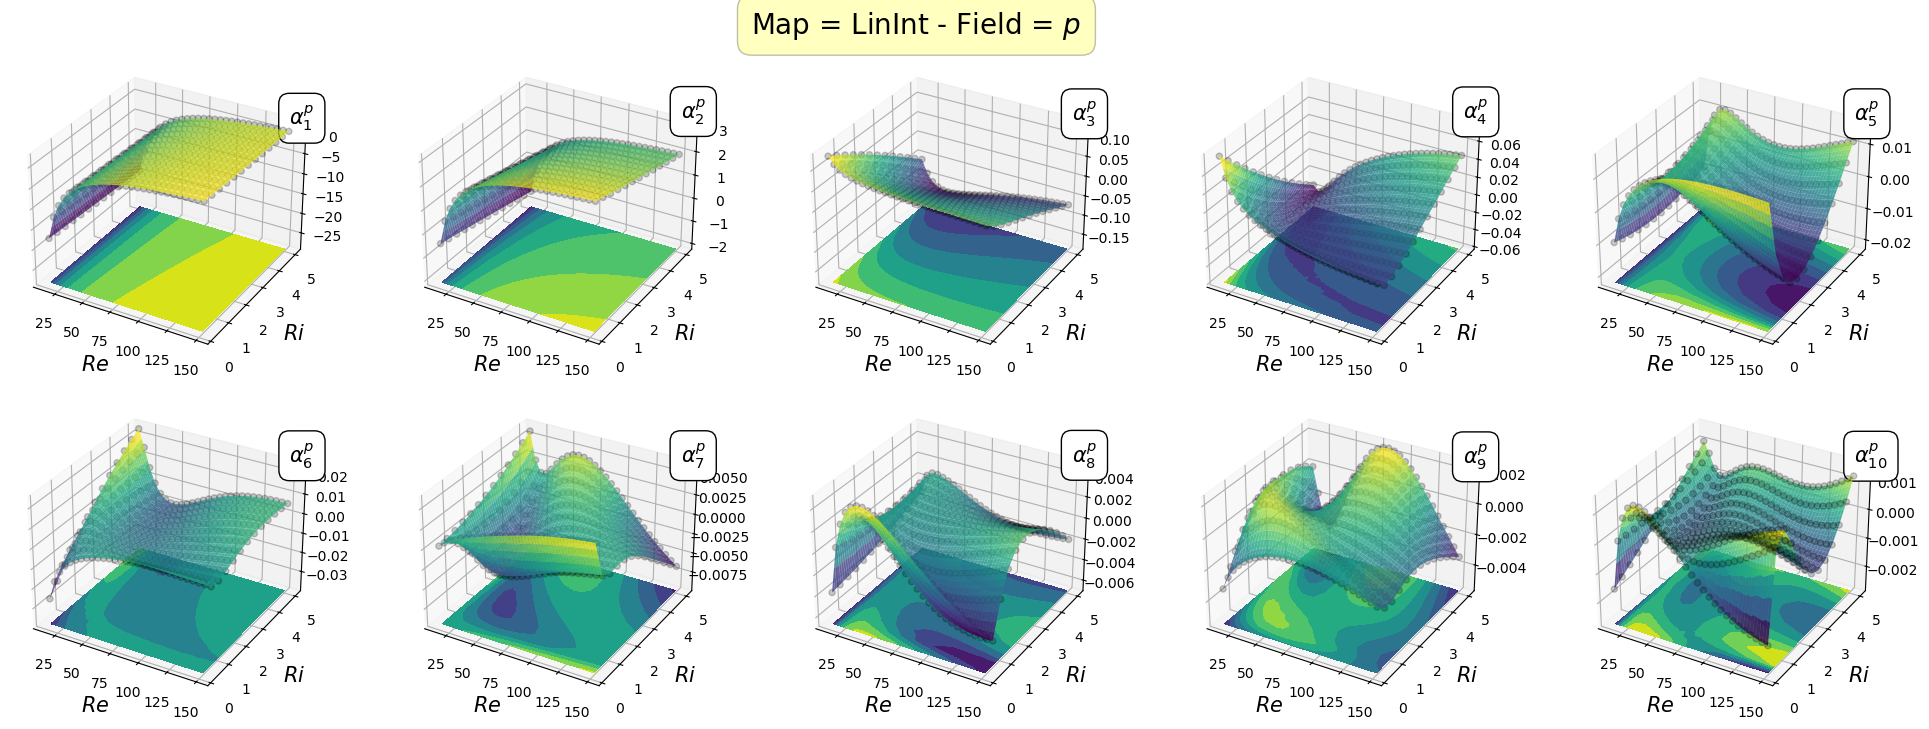

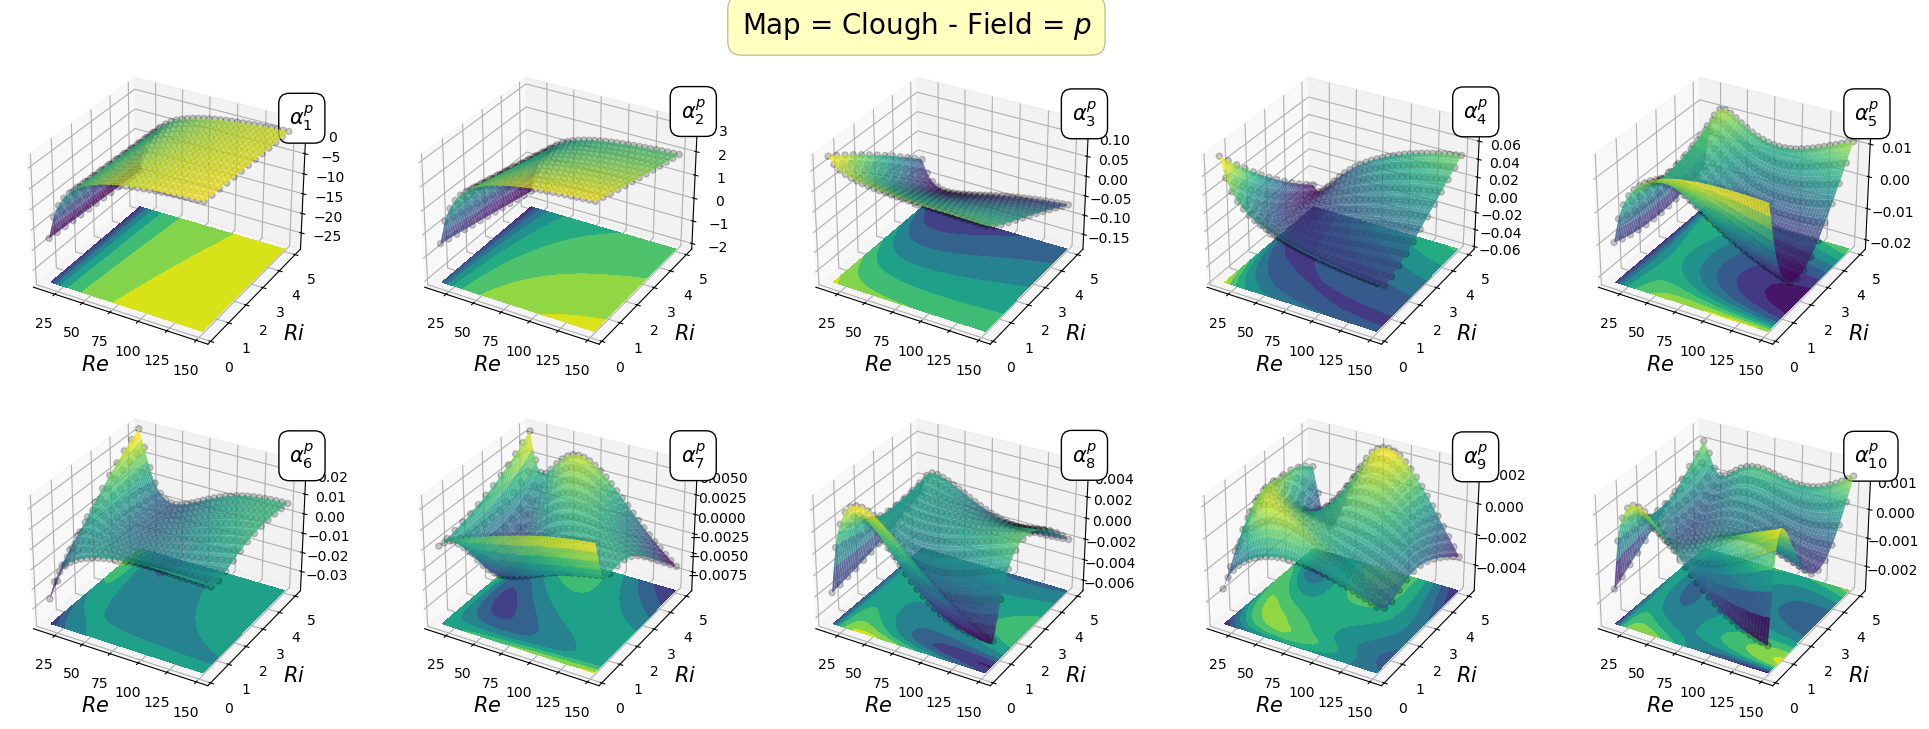

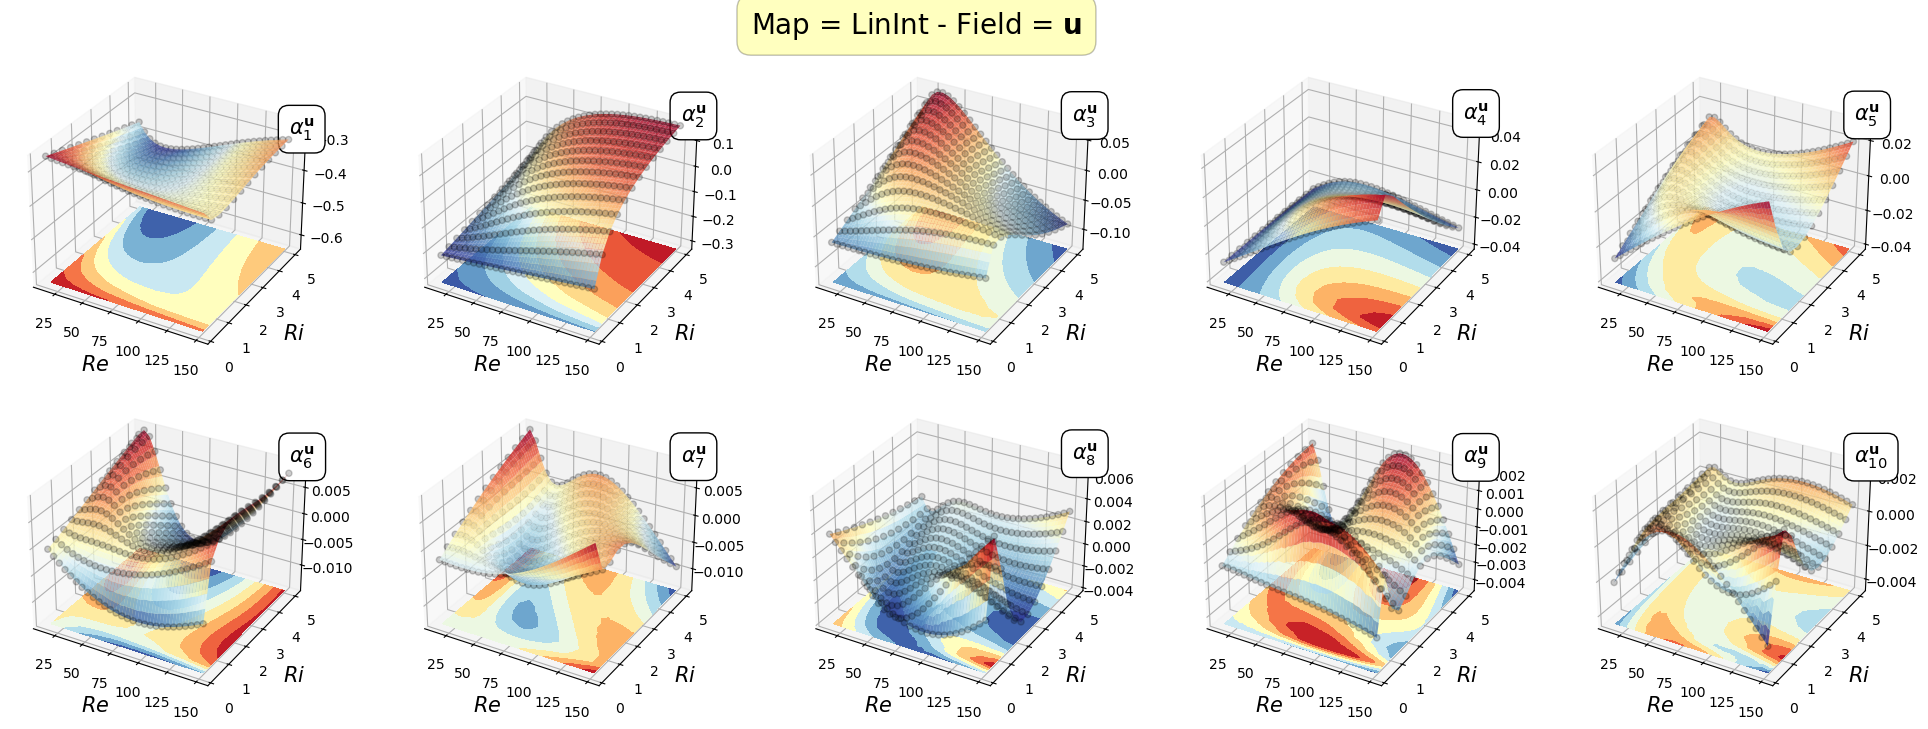

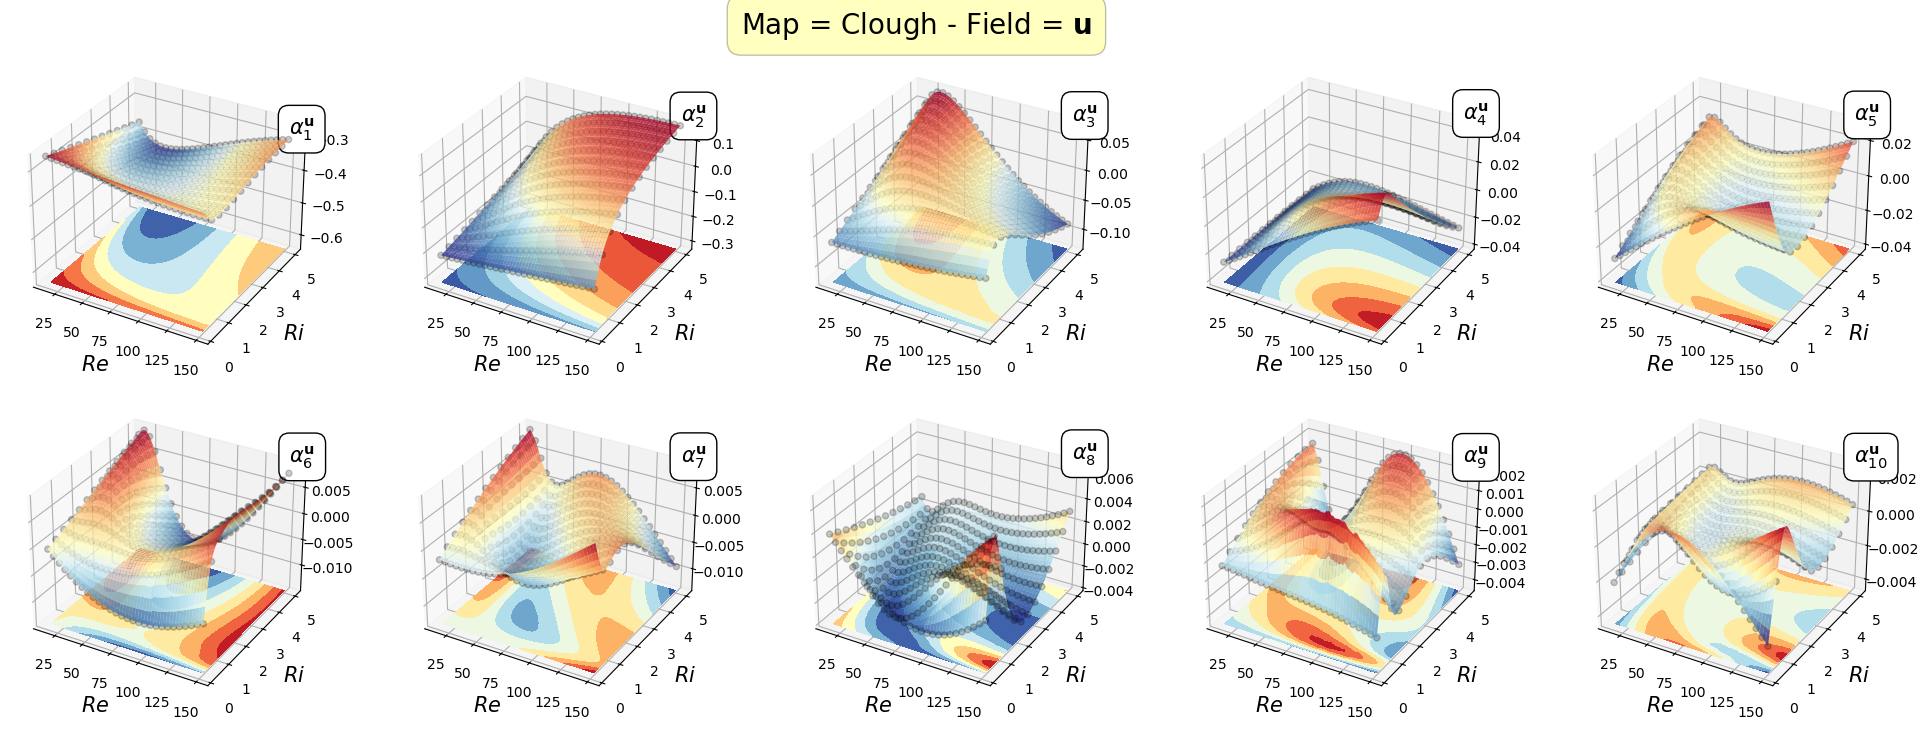

In [127]:
cmaps = [cm.viridis, cm.RdYlBu_r]

for field_i, field in enumerate(pod_var_names):

    Re_plot = np.linspace(min(mu_train[:,0]), max(mu_train[:,0]), 200)
    Ri_plot = np.linspace(min(mu_train[:,1]), max(mu_train[:,1]), 100)

    xx, yy = np.meshgrid(Re_plot, Ri_plot)

    nrows = 2
    ncols = 5

    for map in list(pod_maps[field].keys()):
        fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(5 * ncols, 4 * nrows),
                                subplot_kw={'projection': '3d'})
        axs = axs.flatten()

        for rank in range(nrows * ncols):
            axs[rank].scatter(mu_train[:,0], mu_train[:,1], pod_coeffs[field][:, rank], c='k', marker ='o', alpha = 0.2)
            
            eval_map = pod_maps[field][map][rank](xx, yy)
            surf = axs[rank].plot_surface(xx, yy, eval_map, cmap = cmaps[field_i], alpha=0.8)
            axs[rank].contourf(xx, yy, eval_map, cmap = cmaps[field_i], offset = min(pod_coeffs[field][:, rank]) * (1 - 0.5 * np.sign(min(pod_coeffs[field][:, rank]))))
            axs[rank].set(zlim=(min(pod_coeffs[field][:, rank]) * (1 - 0.5 * np.sign(min(pod_coeffs[field][:, rank]))), max(pod_coeffs[field][:, rank])))
            
            axs[rank].set_xlabel(r'$Re$', fontsize=15)
            axs[rank].set_ylabel(r'$Ri$', fontsize=15)
            axs[rank].text(max(Re_plot), max(Ri_plot), max(pod_coeffs[field][:, rank]) * 1.1, r'$\alpha_{'+str(rank+1)+'}^'+pod_tex_var_names[field_i]+'$', fontsize=15, 
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=1))
        
        fig.subplots_adjust(hspace=0.1, wspace=0.05, top = 0.925)
        fig.suptitle('Map = '+map+' - Field = $'+pod_tex_var_names[field_i]+'$', fontsize=20, bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.25))